<a href="https://colab.research.google.com/github/Lawrence-Krukrubo/fraud_analyst_assignment/blob/main/03_diagnostic_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First let's mount Google Drive so we can navigate the folders as needed
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Let's import some much needed libraries...**

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import random
import xlrd
print('done!')

done!


In [74]:
# Let's get all the colors available in matplotlib
other_colors = []
darker_colors = []
for name, hex in mpl.colors.cnames.items():
    if 'dark' in name:
        darker_colors.append(name)
    else:
        other_colors.append(name)

# Let's finally save the various plot styles in matplotlib
styles = plt.style.available

print(f'darker-colors has {len(darker_colors)},\nother-colors has {len(other_colors)} colors\nplotting styles are {len(styles)}')

darker-colors has 19,
other-colors has 129 colors
plotting styles are 26


In [114]:
# set more matplotlib defaults
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['text.color'] = 'k'
mpl.rc('lines', linewidth=4, linestyle='-')

# Set the plots design to xkcd
# plt.xkcd()  # For xkcd style plots
#plt.rcdefaults()  # to stop xkcd plots

# fontdict for plot titles
fontDict1 = {'fontfamily': 'fantasy',
             'fontsize': 'x-large',
             'fontstyle': 'italic',
             'fontweight': 'heavy',
             'ha': 'center',
             'color': 'darkred',
             'va': 'baseline'}

# fontdict for plot labels
fontDict2 = {'fontfamily': 'fantasy',
             'fontsize': 'medium',
             'fontstyle': 'oblique',
             'fontweight': 'semibold',
             'ha': 'center',
             'color': 'black',
             'va': 'baseline'}

**Let's change our Directory to the Fraud directory containing our data**

In [76]:
FRAUD_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment'
os.chdir(FRAUD_DIR)
print(f'Current Dir: {os.getcwd()}')

Current Dir: /content/gdrive/MyDrive/Colab_Notebooks/fraud_analyst_assignment


In [77]:
# Let's see the contents of the CWD
os.listdir()

['03_diagnostic_analytics.ipynb',
 'Fraud_sample_data.xlsx',
 'questionsAndPoints.gdoc',
 '.ipynb_checkpoints',
 '01_intro_to_fraud_analysis.ipynb',
 '04_predictive_analytics.ipynb',
 '05_prescriptive_analytics.ipynb',
 'fraud_analysis.ipynb',
 'july_df.csv',
 'june_df.csv',
 '02_descriptive_analytics.ipynb']

# Diagnostic EDA (DA2):

**Diagnostic Analytics (DA2):**<br>
Diagnostic analytics are a deeper look at data to attempt to understand the causes of events and behaviours. It’s used largely to answer the question **[“Why did it happen?”]**, and to discover intricate patterns in the data. It is characterized by techniques such as : **drill-down** • **data discovery** • **data mining** • **correlations** • **mutual-information**

1. On a weekly basis, what weeks have the most Fraud?
2. Is there a correlation between weekly transactions count and fraud count?
3. Does fraud tend to increase due to social reasons like public holidays?
4. What Industries are most prone to Fraud?
5. What type of Merchants is most prone?
6. What features of the data are strongly related to fraud occurrences? We can try using Mutual-Information and correlation
7. What are the common patterns among merchants who record the most fraud? For example... 
* What's the average transactions volume per week for high-risk merchants and others? 
* Is there a correlation between fraud-count and transaction-volume-USD when compared to high-risk and other merchants?
* Is there a correlation between weekly fraud count and transaction count for high-risk merchants?
8. Can we use clustering algorithms to learn any meaningful patterns or groupings that can help us learn more about the recent fraud spikes?

Asking and answering these questions give us a deeper understanding of the causes or patterns related to the spike in fraud.

### 5. Exploring Mutual-Information (MI) of variables:
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Mutual information is how many questions you expect the feature to answer about the target. It can help to understand the relative potential of a feature as a predictor of the target, considered by itself. But Mutual Information can't detect interactions between features, is a Univariate metric.

Finally, unlike Correlation that can only detect linear relationships, Mutual Information can detect all kinds and shapes of relations between features and target.

**First, let's read in our June and July datasets from the descriptive analytics session.**

In [78]:
june_df = pd.read_csv('june_df.csv')
july_df = pd.read_csv('july_df.csv')

print(f'june-df shape is: {june_df.shape}\njuly-df shape is: {july_df.shape}\n')
june_df.head()

june-df shape is: (8609, 13)
july-df shape is: (8809, 13)



,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Next, let's combine both datasets...**


In [79]:
combined_df = pd.concat([june_df, july_df])
combined_df.shape

(17418, 13)

**Since we joined two Dataframes with each having index from 0 to `len(df)-1`, let's fix the index of the combined-df**

In [80]:
new_index = list(range(len(combined_df)))
combined_df.index = new_index
print('done!')

done!


**Check for possible NaN values after combination**

In [81]:
combined_df.isna().any().sum()

0

In [82]:
combined_df.head()

,merchant_id,merchant_industry,merchant_category,merchant_country,currency,transaction_week_start_date,channel,transaction_count,transaction_volume_usd,fraud_count,fraud_volume_usd,otp_fraud,otp_all_transactions
0,1,GOODS-PHYSICAL,e-Commerce,Nigeria,NGN,2021-06-07,card,5,231.590551,0,0.0,0,5
1,5,SERVICES-LEGAL,Other,Nigeria,NGN,2021-06-07,card,2,210.203412,0,0.0,0,2
2,9,TRAVEL,Travel & Hospitality,Nigeria,NGN,2021-06-07,card,4,223.097113,0,0.0,0,1
3,11,SERVICES-PROFESSIONAL,Other,Nigeria,NGN,2021-06-07,card,5,212.335958,0,0.0,0,5
4,15,SERVICES-DIGITAL,Digital Services,Nigeria,NGN,2021-06-07,card,8,550.131234,0,0.0,0,8


**Next, we make a copy of `combined_df` for mutual-information analysis.**

In [83]:
mi_combined = combined_df.copy(deep=True)
print('done!')

done!


In [84]:
# Next, pop the targets

target = mi_combined.pop('fraud_count')

In [85]:
# Next, get separate list for numeric and categoric columns

num_cols = list(mi_combined._get_numeric_data().columns)
cat_cols = list(set(mi_combined.columns) - set(num_cols))
print('done!')

done!


In [86]:
# Next, let's label-encode categorical variables

for colname in cat_cols:
    mi_combined[colname], _ = mi_combined[colname].factorize()
print('done!')

done!


**All categorical features should now have numerical datatypes**

In [87]:
mi_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17418 entries, 0 to 17417
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_id                  17418 non-null  int64  
 1   merchant_industry            17418 non-null  int64  
 2   merchant_category            17418 non-null  int64  
 3   merchant_country             17418 non-null  int64  
 4   currency                     17418 non-null  int64  
 5   transaction_week_start_date  17418 non-null  int64  
 6   channel                      17418 non-null  int64  
 7   transaction_count            17418 non-null  int64  
 8   transaction_volume_usd       17418 non-null  float64
 9   fraud_volume_usd             17418 non-null  float64
 10  otp_fraud                    17418 non-null  int64  
 11  otp_all_transactions         17418 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.7 MB


**Since our target `fraud_count` is a numerical feature, we shall use the mutual_info_regression method...**

In [88]:
# Next, identify discrete features

discrete_features = mi_combined.dtypes == int
print('done')

done


In [89]:
from sklearn.feature_selection import mutual_info_regression as mi

def make_mi_scores(X, y, discreteFeatures):
    mi_scores = mi(X, y, discrete_features=discreteFeatures)
    mi_scores = pd.Series(mi_scores, name='MI_scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

**Now, let's get the Mutual Info scores for the combined data**

In [90]:
mi_scores = make_mi_scores(mi_combined, target, discrete_features)
print('done!')

done!


**Let's see a sample of the top scores**

In [91]:
mi_scores.head()

fraud_volume_usd          0.034052
transaction_volume_usd    0.015094
merchant_industry         0.012122
otp_fraud                 0.012080
merchant_category         0.011607
Name: MI_scores, dtype: float64

In [92]:
def plot_mi_scores(mi_scores):
    scores = mi_scores.sort_values(ascending=True)
    plt.figure(dpi=100, figsize=(8, 5))

    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores", fontdict=fontDict1)

    plt.show()

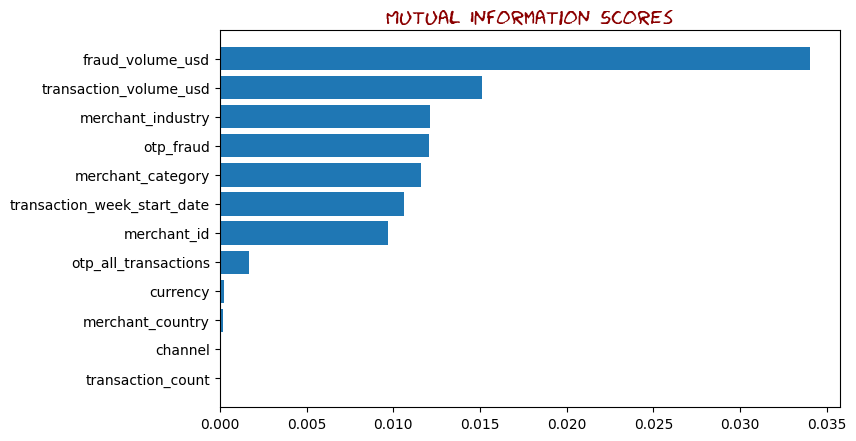

In [93]:
plot_mi_scores(mi_scores)

From the Mutual-Information analysis, we can see the features that are most discriminative to `fraud_count` . Therefore, we can proceed with our analysis focusing on these top features. Let's update the `mi_combined` dataframe to have only these features that tell us something about `fraud-count`.
 

### 6. Selecting Top MI-Scores features:

**Let's select the top features from MI analysis and ofcourse add the `fraud_count` column as our target. This can be used for any machine-learning task.**

In [94]:
# We'd use a threshold of 0.002 based on the MI chart above.
t = 0.002
top_mi = [ind for ind in list(mi_scores.index) if mi_scores[ind] >= t]

In [95]:
# Finally, append target column
top_mi.append('fraud_count')  

In [96]:
top_mi

['fraud_volume_usd',
 'transaction_volume_usd',
 'merchant_industry',
 'otp_fraud',
 'merchant_category',
 'transaction_week_start_date',
 'merchant_id',
 'fraud_count']

**Now, we re-create the `mi_combined` df but with only the features from MI-analysis**

In [97]:
# Now select only MI-features
mi_combined = combined_df[top_mi]

print(f'MI-combined shape is: {mi_combined.shape}\n')
mi_combined.head(3)

MI-combined shape is: (17418, 8)



,fraud_volume_usd,transaction_volume_usd,merchant_industry,otp_fraud,merchant_category,transaction_week_start_date,merchant_id,fraud_count
0,0.0,231.590551,GOODS-PHYSICAL,0,e-Commerce,2021-06-07,1,0
1,0.0,210.203412,SERVICES-LEGAL,0,Other,2021-06-07,5,0
2,0.0,223.097113,TRAVEL,0,Travel & Hospitality,2021-06-07,9,0


### 7. Analyzing Weekly Fraud Trends:
#### Trying to identify weeks where Fraud is high to check if there are possible social reasons for that.

In [98]:
june_weeks = list(june_df.transaction_week_start_date.unique())
july_weeks = list(july_df.transaction_week_start_date.unique())

# Let's add these together
june_weeks.extend(july_weeks)

# Let's rename the extension
weekly_dates = june_weeks

**Get the weekly fraud-count and transactions-count...**

In [99]:
# save the weekly dates intuitively for plotting sakes

length = len(weekly_dates)
weekly_index = ['June_W'+str(i) if i <=  length//2 else 'July_W'+str(i-4) for i in range(1, length+1) ]

In [100]:
def get_weekly_data(col1, col2, kind='sum', name=None, df=combined_df):
    """ Function to get weekly aggregate data

    @param df: dataframe to groupby on
    @param col1 and col2: str cols to groupby and index on
    @param kind: str, kind of operation e.g mean, sum, count
                default=sum
    @param name: str, name of resulting series obj, default=None
    @return: A pandas series object
    """
    kind = kind.lower()
    assert kind in ['sum', 'mean', 'count'],'ERROR:Must be sum, mean or count'

    if kind == 'sum':
        serie = df.groupby([col1])[col2].sum()
        serie.index = weekly_index
        serie.name = name

    elif kind == 'mean':
        serie = df.groupby([col1])[col2].mean()
        serie.index = weekly_index
        serie.name = name

    else:
        serie = df.groupby([col1])[col2].count()
        serie.index = weekly_index
        serie.name = name

    return serie

In [101]:
col1 = 'transaction_week_start_date'
col2 = 'fraud_count'
name = 'Weekly Fraud-Count'

weekly_fraud_count = get_weekly_data(col1, col2, name=name)
weekly_fraud_count

June_W1    256
June_W2    284
June_W3    182
June_W4    211
July_W1    112
July_W2    109
July_W3     70
July_W4    100
Name: Weekly Fraud-Count, dtype: int64

In [103]:
col1 = 'transaction_week_start_date'
col2 = 'transaction_count'
name = 'Weekly Transaction-Count'

weekly_transact_count = get_weekly_data(col1, col2, name=name)
weekly_transact_count

June_W1     997735
June_W2    1064033
June_W3    1073565
June_W4    1042017
July_W1    1030233
July_W2     965332
July_W3     978273
July_W4    1015426
Name: Weekly Transaction-Count, dtype: int64

Let's plot the weekly fraud trends...

In [143]:
def plot_weekly_trends(s1, s2, plot='bar'):
    """Method for plotting weekly fraud data
    """
    plt.figure(figsize=(24,6))
    styl = random.sample(styles, 1)
    plt.style.use(styl)
    print(f'style: {styl}')

    plt.subplot(1,2,1)
    plt.plot(s1, color='red')
    plt.xlabel('Week', fontdict=fontDict2)
    plt.ylabel('Count', fontdict=fontDict2)
    plt.title(s1.name, fontdict=fontDict1)

    if plot == 'bar':
        plt.subplot(1,2,2)
        plt.bar(x=s2.index, height=list(s2), color=random.sample(darker_colors, 8))
        plt.title(s2.name, fontdict=fontDict1)
        plt.xlabel('Week', fontdict=fontDict2)
        plt.ylabel('Count', fontdict=fontDict2)
    else:
        plt.subplot(1,2,2)
        plt.plot(s2, color='Red')
        plt.title(s2.name, fontdict=fontDict1)
        plt.xlabel('Week', fontdict=fontDict2)
        plt.ylabel('Count', fontdict=fontDict2)

    plt.show()

style: ['seaborn-whitegrid']


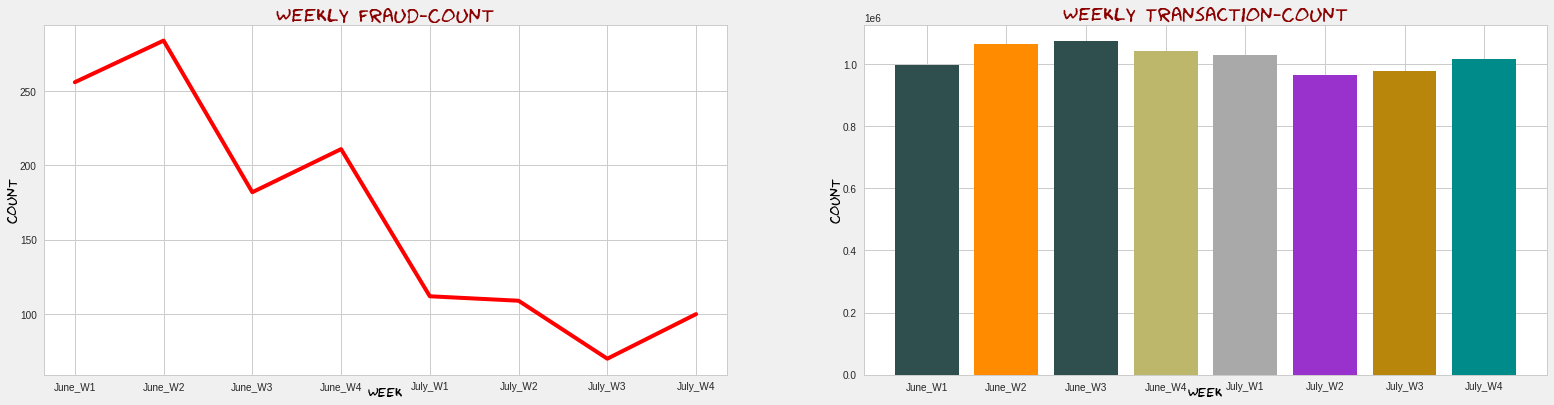

In [144]:
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2)

From the weekly fraud trend data, we can see that generally, fraud is trending downward. This does not mean it may not trend upward in the future, though, as can be seen in the rise in last week of July.

* Fraud starts high at about 250 for June-Wk-1
* It increases to about 280 for June-Wk-2
* Then it drops to about 180 in June-Wk-3
* Then it rises to about 210 in June-Wk-4
* And just keeps dropping weekly in July, lowest in July-Wk-3
* Starts rising again in July-Wk-4

While the weekly transactions count remain fairly constant between 970k and 1.07 million. Therefore, the data does not support the hypothesis that as fewer transactions are done, fewer fraud tends to be done. This is because the rate of fraud tends to decrease week by week, even though fairly same transactions are done. In otherwords, there's a weak correlation if any between weekly fraud count and weekly transactions count.

Although correlation does not imply cauation, we can see that:-   
* June 14th which marks the start of June-Wk-2 is a national holiday called **democracy-day** in Nigeria
* June 20th is Father's day
* June 23rd is also a regional holiday in Ebonyi State
* Tuesday July 20th and Wednesday July 21st are also public holidays called **id-el-kabir**

[source1](https://www.timeanddate.com/holidays/nigeria/), [source2](https://www.officeholidays.com/countries/nigeria/2021)

### 8. Drilling down on Fraudulent transactions data:

In [ ]:
june_fraud_specific = june_df[june_df.fraud_count > 0]
print(f'June Fraud-Specific data shape is: {june_fraud_specific.shape}\n')

june_fraud_specific.head(3)

In [ ]:
july_fraud_specific = july_df[july_df.fraud_count > 0]
print(f'July Fraud-Specific data shape is: {july_fraud_specific.shape}\n')

july_fraud_specific.head(3)

**Let's see the distribution of fraud across `merchant_category` for June and July**

In [ ]:
def selection(df, arr, empty_arr):
    """helper method for function below
    """
    for item in arr:
        temp = df[df[var] == item]
        empty_arr.append(sum(temp['fraud_count']))


def get_fraud_distribution_per_var(df1, df2, var, names, s=selection):
    """Function to derive fraud distribution per variable
        for both June and July datasets.

    @param df1 and df2; June and July Dataframes
    @param var: The specific categorical variable to split over
    @param names: A list of string titles for each Series
    @return: Two Series sorted descending
    """
    unique1 = list(df1[var].unique())
    unique2 = list(df2[var].unique())
    s1_list = []
    s2_list = []

    s(df1, unique1, s1_list)
    s(df2, unique2, s2_list)

    s1 = pd.Series(s1_list, index=unique1, name=names[0])
    s2 = pd.Series(s2_list, index=unique2, name=names[1])
    s1.sort_values(ascending=False, inplace=True)
    s2.sort_values(ascending=False, inplace=True)

    # compute percentages
    s1 = (s1 / sum(s1)) * 100
    s2 = (s2 / sum(s2)) * 100

    return s1, s2

In [ ]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_category'
names = ['Merchant-Category Fraud: June', 'Merchant-Category Fraud: July']

june_merchant_cat_fraud, july_merchant_cat_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

In [ ]:
june_merchant_cat_fraud

In [ ]:
july_merchant_cat_fraud

**Let's visualize the top 5 merchant categories for fraudulent transactions**

In [ ]:
sup_title = 'Top 5 Merchant-Categories for Fraud: June Vs July'
titles = ['June Merchant-Category', 'July Merchant-Category']
s1 = june_merchant_cat_fraud[:5]
s2 = july_merchant_cat_fraud[:5]
colours = ['red', 'blue', 'yellow', 'magenta', 'green']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

We can see that two merchant-categories make up more than 98% of total fraud. These are
1. Betting
2. Financial services

**Let's see the distribution of fraud across `merchant_industry` for June and July**

In [ ]:
df1 = june_fraud_specific
df2 = july_fraud_specific
var = 'merchant_industry'
names = ['Merchant-Industry Fraud: June', 'Merchant-Industry Fraud: July']

june_merchant_ind_fraud, july_merchant_ind_fraud = get_fraud_distribution_per_var(df1, df2, var, names)
print('done!')

In [ ]:
june_merchant_ind_fraud

In [ ]:
july_merchant_ind_fraud

In [ ]:
sup_title = 'Top 5 Merchant-Industries for Fraud: June Vs July'
titles = ['June Merchant-Industry', 'July Merchant-Industry']
s1 = june_merchant_ind_fraud[:5]
s2 = july_merchant_ind_fraud[:5]
colours = ['magenta', 'yellow', 'blue', 'green', 'black']
size = (24, 6)

compare_pie_chart(sup_title, titles, s1, s2, size, colours)

From the two sets of Piecharts above, we can surmise that...<br>
Merchants in the **Betting** and **Financial Services** category, who operate within the **Betting** and **Lending** industries recorded more than 98% of total frauds across merchant-categories and more than 96% of total fraud across merchant-industries, for the months of June and July 2021.

**The next step is to identify these merchants...**

So, we want to select merchants in the Betting and Financial-Services(FS) categories that operate within the Betting and Lending industries.

In [ ]:
# First, we select Merchants whose category is either FS or Betting
high_risk = combined_df[(combined_df.merchant_category == 'Betting') \
                                    | (combined_df.merchant_category == 'Financial Services')]

# Then from these, we select those whose industries are BETTING or LENDING
high_risk = high_risk[(high_risk.merchant_industry == 'BETTING') \
                                              | (high_risk.merchant_industry == 'LENDING')]

# We do it this way, just incase BETTING and LENDING industries also exist in 
# other marchant-categories aside from Betting and Financial-Services.

print(f'Top-Concern-Merchants shape is: {high_risk.shape}\n', end=' ')
high_risk.head()

**Since we've identified them, let's also separate the others**

In [ ]:
others_index = list(set(list(combined_df.index)) - set(list(high_risk.index)))
(len(others_index) + len(high_risk.index)) == len(combined_df.index)

In [ ]:
others = combined_df.iloc[others_index, :]
print(len(others_index) == len(others))
print(f'others shape: {others.shape}\n')
others.head(3)

**Let's see the actual split of distinct merchants in the High-Risk industries and other industries.**

In [ ]:
num_high_risk_merchants = high_risk.merchant_id.nunique()
num_other_merchants = others.merchant_id.nunique()

print(f'High-Risk Merchants are: {num_high_risk_merchants}\nWhile others are {num_other_merchants} in total.')

In [ ]:
def plot_merchants_split(names, val1, val2, size, sup_title, color=colours):
    """Function to plot the split of merchants
        across High-Risk and low-Risk bounds.

    @param names: A list of string names
    @param val1 & val2: Integer values
    @param size: A tuple of figure size dimensions
    @param sup_title: String, the overall suptitle of both charts
    """

    plt.figure(figsize=size)

    fontDict ={'fontsize': 20,
        'fontweight' : 'bold',
        'verticalalignment': 'baseline',
      'color': 'Red',
       'family':'DejaVu Sans'}

    total = val1 + val2

    s1 = pd.Series([val1, val2], index=names, 
                       name='Count of High and Low Risk Merchants')
    s2 = pd.Series([(val1 / total)*100, (val2 / total)*100], index=names,
                       name='Percentage of High and Low Risk Merchants')
    
    plt.suptitle(sup_title, y=1.05, fontdict=fontDict)
    fontDict['fontsize'] = 14
    
    plt.subplot(1,2,1)
    plt.bar(x=s1.index, height=list(s1), color=colours)
    plt.xlabel('Merchant', fontdict=fontDict)
    plt.ylabel('Count', fontdict=fontDict)
    fontDict['fontsize'] = 18
    fontDict['color'] = 'Black'
    plt.title(s1.name, fontdict=fontDict)

    plt.subplot(1,2,2)
    plt.pie(s2, 
       autopct='%1.1f%%',
       startangle=90,
       colors=colours,
       shadow=True,
       pctdistance=1.06)
    plt.title(s2.name, fontdict=fontDict)
    plt.axis('equal')
    plt.legend(labels=s2.index, loc='upper right')
 
    plt.show()

In [ ]:
names = ['High-Risk', 'Low-Risk']
val1, val2 = num_high_risk_merchants, num_other_merchants
sup_title = 'Count Plot and Percentage Plot of High-Risk vs Low-Risk Merchants'
colours = ['Purple', 'Teal']

plot_merchants_split(names, val1, val2, size, sup_title)

From these charts, we can see that only 8% of Merchants constitute about 98% of fraud transactions. We need to take a much closer look at how these merchants conduct their day-to-day activities.

### 9. Finding Distinct Patterns of High-Risk Merchants

What are the common patterns among merchants who record the most fraud? For example: 
* What's the average transactions volume per week for high-risk merchants and others? 
* Is there a correlation between fraud-count and transaction-count when compared to high-risk and other merchants? 


**Let's see the descriptive statistics for these `top-concern` merchants**

In [ ]:
# Let's see for Categorical Variables of top-concern merchants

high_risk.describe(include='object').T

In [ ]:
# Let's see for Categorical Variables of other merchants

others.describe(include='object').T

In [ ]:
# Let's see for Numerical Variables of top-concern merchants

high_risk.describe().T

In [ ]:
# Let's see for Numerical Variables of other merchants

others.describe().T

From the describtive stats above, we can see that...
* High-Risk merchants on average performed 3538 transactions within these two months, whie other merchants did an average of 175 transactions.
* High-Risk merchants in the Betting and Lending business did an average of `$32k` USD for these two months. Others did an average of `$4.2k` USD.

* **What's the average transactions count per week for high-risk merchants and others?** 

In [ ]:
high_risk.head(2)

In [ ]:
def find_ave_weekly_trans(df1, df2, dates):
    """Function to find the average transactions done weekly
    by high-risk and other merchants.

    @param df1 and df2: Dataframes for high-risk and other merchants
    @param col1 and col2: strings, column names to compute ratios
    @return: Dataframe of computed results
    """

    june = 'Jun_W'
    july = 'Jul_W'
    cols = ['High_Risk', 'Others']
    inds = []
    ave_trans = []
    i, j = 0, 0

    for date in dates:
        temp_list = []
        temp1 = df1[df1['transaction_week_start_date'] == date]
        temp2 = df2[df2['transaction_week_start_date'] == date]
        temp_list.append(temp1.transaction_count.mean())
        temp_list.append(temp2.transaction_count.mean())
        ave_trans.append(temp_list)
        if dates.index(date) < 4:
            i+=1
            inds.append(june+str(i))
        else:
            j+=1
            inds.append(july+str(j))
    
        ratio_df = pd.DataFrame(ave_trans, index=inds, columns=cols)
       
    return ratio_df

In [ ]:
df1 = high_risk
df2 = others
dates = weekly_dates

ave_weekly_trans_df = find_ave_weekly_trans(df1, df2, dates)
ave_weekly_trans_df

In [ ]:
print(f'On a weekly average, High-Risk merchants do {round(ave_weekly_trans_df.High_Risk.mean())}, while others do {round(ave_weekly_trans_df.Others.mean())} transactions.')

In [ ]:
# First let's define a Font Dict
fontDict ={'fontsize': 18,
        'fontweight' : 'bold',
        'verticalalignment': 'baseline',
      'color': 'Black',
       'family':'DejaVu Sans'}

ave_weekly_trans_df.plot(kind='area', figsize=(18,6))
plt.title('Average Weekly Transactions: High-Risk vs Other Merchants', fontdict=fontDict)

fontDict['fontsize'] = 14
fontDict['color'] = 'Red'
plt.xlabel('Week', fontdict=fontDict)
plt.ylabel('Count', fontdict=fontDict)
plt.show()

**Observing weekly Fraud and Transactions trend for High-Risk Merchants.**

In [ ]:
weeks_list = weekly_dates
df_list = [high_risk]
names = ['Weekly Fraud Count: High-Risk', 'Weekly Transaction Count: High-Risk']

weekly_fraud_count, weekly_transact_count = get_weekly_fraud_and_transaction_counts(weeks_list, df_list, names=names)

In [ ]:
weekly_fraud_count

In [ ]:
weekly_transact_count

In [ ]:
s1 = weekly_fraud_count
s2 = weekly_transact_count

plot_weekly_trends(s1, s2)

This relationship does not tell us anything distinct about the Top-Concern or High-Risk merchants, the weekly data looks very similar to the weekly trend for the entire data set.

The only distinct trait seen so far is that Merchants in the high-Risk industries of Betting and Lending perform a lot more transactions on average weekly, than regular merchants and record over 96% of all fraud attempts.

### 10. Feature-Engineering:

As we prepare to use our data for Machine-Learning activities, we need to prepare the data accordingly by performing certain activities


In [ ]:
# First, make a copy of the mi_combined df

copy_mi = mi_combined.copy(deep=True)

In [ ]:
def plot_hist(df,
              df_name,
              color=None,
              suptitle=None,
              size=(16,12),
             linewidth=1.5,
             edgecolor='black',
             density=True):
    
    num_cols = list(df.select_dtypes(include='number').columns)
    
    title = f'Numerical Values Distribution: {df_name}'
    if suptitle:
        title = df_name+': '+suptitle
        
    df[num_cols].hist(figsize=size,
                     linewidth=linewidth,
                     edgecolor=edgecolor,
                     color=color,
                     density=density)
    
    plt.suptitle(title, fontweight='bold', fontsize=16, y=0.95)
    plt.show()

In [ ]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

**Checking for outliers**

In [ ]:
num_cols = list(copy_mi.select_dtypes(include='number').columns)
cat_cols = list(copy_mi.select_dtypes(exclude='number'))

In [ ]:
def find_extreme_boundaries(variable, df, distance=3):
    """This method computes and returns the upper
        and lower outlier boundaries for each variable.
    """

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    if upper_boundary == lower_boundary:
        upper_boundary = max(df[variable])
        lower_boundary = min(df[variable])

    return upper_boundary, lower_boundary

**Let's see the extreme outliers in the numerical columns**

In [ ]:
def extreme_outliers_toDF(df, cols):
    """This method computes the outliers
    in a dataframe and returns these values as a
    dataframe 

    @param df: A dataframe
    @param distance: The limit of outlier, max & default=3
    """
    outliers_dict = {}
    for col in cols:
        upper, lower = find_extreme_boundaries(col,df)
        outliers = np.where(df[col] > upper, True,
        np.where(df[col] < lower, True, False))
        count_outliers = np.sum(outliers)
        outliers_dict[col] = [count_outliers]
    
    outliers_df = pd.DataFrame(outliers_dict).T
    outliers_df.columns = ['count']
    return outliers_df

In [ ]:
ext_outliers_df = extreme_outliers_toDF(copy_mi, num_cols)
ext_outliers_df

**let's clip outliers to lower or max values**

In [ ]:
def clip_extreme_outliers(main_df, sub_df):
    """Function clips extreme outliers

    @param df: a dataframe
    @param cols: list of columns to clip from
    """
    indx = list(sub_df.index)

    for ind in indx:
        if sub_df.at[ind, 'count'] > 100:
            high, low = find_extreme_boundaries(ind, main_df)
            print(ind,':', high, low)
            main_df[ind] = np.where(main_df[ind] > high, high,
                           np.where(main_df[ind] < low, low, main_df[ind]))
    return main_df

In [ ]:
# Let's clip the extreme outliers
copy_mi = clip_extreme_outliers(copy_mi, ext_outliers_df)
print('done!')

In [ ]:
# Check for extreme outliers
extreme_outliers_toDF(copy_mi, num_cols)

**Normalizing Numeric data with Quantization and log-transform based on the shape of the distribution**

All aside from `merchant_id` will be normalized with log_transform

In [ ]:
copy_mi.isna().any()

In [ ]:
copy_mi.head()

In [ ]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

**From the data, we'd normalize `otp_all_transactions` and `transactions_volume_usd` and `merchant_id` with quantization, while the rest will be log-tranform** 

In [ ]:
def log_transform(df, cols):
    for col in cols:
        data = df[col].astype('float').values
        # avoid division by zero issues
        data = np.log(data, out=data, where=data > 0.0000000001)
        df[col] = list(data)
    print('done!')

In [ ]:
col_quant = ['otp_all_transactions', 'transaction_volume_usd', 'merchant_id']
col_log = [col for col in num_cols if col not in col_quant]

log_transform(copy_mi, col_log)

In [ ]:
copy_mi.isna().any()

In [ ]:
numQuantiles = 20
colsQuantiles = col_quant

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for string in colsQuantiles:
    if string in num_cols:
        copy_mi[string] = createQuantiles(copy_mi[string], numQuantiles)
print('done!')

In [ ]:
copy_mi.isna().any()

In [ ]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

In [ ]:
# Now, scale the numeric columns

for string in num_cols:
  copy_mi[string] = minMaxScaler(copy_mi[string])
print('done!')

In [ ]:
copy_mi.isna().any()

In [ ]:
df_name = 'Top-MI-Features DF'
colour = 'yellow'
sup_title = 'Histogram of Numerical Features'

plot_hist(copy_mi, df_name, color=colour, suptitle=sup_title)

In [ ]:
copy_mi.head()

**Encoding Categorical variables**

We may choose either to one-hot-encode these or merely discretize them numnerically using the factorize() function.

In [ ]:
cat_cols = list(copy_mi.select_dtypes(exclude='number'))
cat_cols

In [ ]:
# Let's factorize and scale the categorical columns same time

for cat in cat_cols:
    copy_mi[cat], _ = copy_mi[cat].factorize()
    copy_mi[cat] = minMaxScaler(copy_mi[cat])
print('done!')

In [ ]:
copy_mi.isna().any()

In [ ]:
copy_mi.head()

### 10. Applying Clustering Machine Learning Algorithm: K-Means

Centroid-based(CB) clustering are easier to use and interpret than density-based(DB) clustering. Although CB is susceptible to outliers and even clusters outliers, while DB is resistant to outliers. 

**Therefore, let's define some helper methods for K-means algorithm**

In [ ]:
import math
import numpy.linalg as nla
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

In [ ]:
def dfSimilarity(df, centroids):
    """Calculate similarities for dataframe input.
        We use the Euclidean Distance calculation

    We need to calculate np.sqrt(||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|),
    and do so using matrix operations

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @return: An array of similarity scores
    """
    numPoints = len(df.index)
    numCentroids = len(centroids.index)

    ## Strictly speaking, we don't need to calculate the norm of points
    # because it adds a constant bias to distances
    # But calculating it so that the similarity doesn't go negative
    # And that we expect similarities in [0,1] which aids debugging

    # find the dot-product of each row or observation in df
    pointNorms = np.square(nla.norm(df, axis=1))
    # reshape the 1D array of dot-products to a column array
    pointNorms = np.reshape(pointNorms, [numPoints, 1])

    # # find the dot-product of each row or observation in centroids
    centroidNorms = np.square(nla.norm(centroids, axis=1))
    # reshape the 1D array of dot-products to a row array
    centroidNorms = np.reshape(centroidNorms, (1, numCentroids))

    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(
        df, np.transpose(centroids))
    
    # Divide by the number of feature directly if no OHE-features,
    # Else divide by original feature size if OHE
    similarities = similarities / df.shape[1]

    # numerical artifacts lead to negligible but negative values 
    # that go to NaN on the root, so let's clip such features
    similarities = similarities.clip(min=0.0)

    # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities

In [ ]:
def initCentroids(df, k, feature_cols):
    """Helper function to initialize centroids randomly

    @param df: a preprocesed dataframe for k-means
    @param k: An integer for number of clusters/centroids
    @param feature_cols: an array of string feature names for k-means
    @return: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
    # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True)
    return centroids

In [ ]:
def pt2centroid(df, centroids, feature_cols):
    """Helper function to calculate similarities between 
    all points and centroids, Assign points to the 
    closest centroids and save that distance.

    @param df: a dataframe, shape(m, n)
    @param centroids: subset of df, shape(k, n), 
                     where k is cluster size
    @param feature_cols: an array of string feature names for k-means
    @return: df with centroid and pt2centroid columns data
    """
    numCentroids = len(centroids.index)
    numExamples = len(df.index)

    # dfSimilarity = Calculate similarities for dataframe input
    dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
    return df

In [ ]:
def recomputeCentroids(df, centroids, feature_cols):
    """Helper function to recompute centroids.
        Thus, for every centroid, recompute it as an
        average of the points assigned to it.

    @param df: a preprocesed dataframe for k-means
    @param feature_cols: an array of string feature names for k-means
    @param centroids: dataframe of centroids(sliced from df size(k, len(feature_cols)))
    """
  
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen,
                            feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
        clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
        centroids.loc[cen] = clusterAvg
    return centroids

**Finally, we put all the helper functions together in the kmeans function below**

In [ ]:
def kmeans(df, k, feature_cols, verbose, max_iter=100):
    flagConvergence = False
    maxIter = max_iter
    iter = 0  # initialize counter to 0

    centroids = initCentroids(df, k, feature_cols)
    while not (flagConvergence):
        iter += 1
        #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)

        # Perform k-means
        df = pt2centroid(df, centroids, feature_cols)
        centroids = recomputeCentroids(df, centroids, feature_cols)

        # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print('Total distance:' + str(np.sum(df['pt2centroid'])))
        if (iter > maxIter):
            print('k-means did not converge! Reached maximum iteration limit of ' \
                + str(maxIter) + '.')
            sys.exit()
            return
    print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
    return df, centroids

**Find optimal number of clusters**

In [ ]:
initial_k = 100  # set k to something high

feature_cols = copy_mi.columns.values  # save original columns

# initialize every point to an impossible value, the k+1 cluster
copy_mi['centroid'] = initial_k + 1

# init the point to centroid distance to an impossible value "5" (>1)
copy_mi['pt2centroid'] = 5

# Let's see the new columns
copy_mi.head()

In [ ]:
# Plot loss vs number of clusters
copy_mi2 = copy_mi.copy(deep=True)

def lossVsClusters(kmin, kmax, kstep, copy_mi2):
    kmax += 1  # include kmax-th cluster in range
    kRange = range(kmin, kmax, kstep)
    loss = np.zeros(len(kRange))
    lossCtr = 0

    for kk in kRange:
        [copy_mi2, centroids] = kmeans(copy_mi2, kk, feature_cols, 0)
        loss[lossCtr] = np.sum(copy_mi2['pt2centroid'])
        lossCtr += 1
    plt.figure(figsize=size)
    plt.scatter(kRange, loss)
    plt.title('Loss vs Clusters Used')
    plt.xlabel('Number of clusters')
    plt.ylabel('Total Point-to-Centroid Distance')


kmin =   4# @param
kmax = 80  # @param
kstep =   2# @param
lossVsClusters(kmin, kmax, kstep, copy_mi2)

**Let's now run K-means**

From the optimal clusters, I'd choose `k = 42`

In [ ]:
# Run the K-means query
k = 42
copy_mi, centroids = kmeans(copy_mi, k, feature_cols, verbose=1)

print("Data for the first few rows, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
copy_mi.head()

### 11. Evaluating The K-Means Algorithm

**Quality of Clustering**

First, perform a visual check that the clusters look as expected, and that examples that are considered similar do appear in the same cluster. Then check these commonly-used metrics:

1. Cluster cardinality:<br>Cluster cardinality is the number of examples per cluster. Plot the cluster cardinality for all clusters and investigate clusters that are major outliers
2. Cluster magnitude:<br>Cluster magnitude is the sum of distances from all examples to the centroid of the cluster. Similar to cardinality, check how the magnitude varies across the clusters, and investigate anomalies.
3. Magnitude vs. Cardinality:<br>Notice that a higher cluster cardinality tends to result in a higher cluster magnitude, which intuitively makes sense. Clusters are anomalous when cardinality doesn't correlate with magnitude relative to the other clusters. Find anomalous clusters by plotting magnitude against cardinality. 

In [ ]:
def clusterCardinality(df):
    k = np.max(df['centroid']) + 1
    k = int(k)  # ensuring k is an int
    print('Number of clusters:' + str(k))
    clCard = np.zeros(k)
    for kk in range(k):
        clCard[kk] = np.sum(df['centroid'] == kk)
    clCard = clCard.astype(int)
    print("Cluster Cardinality:"+str(clCard)) 
    plt.figure()
    plt.bar(range(k), clCard)
    plt.title('Cluster Cardinality')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Points in Cluster')
    return clCard

In [ ]:
def clusterMagnitude(df):
    k = np.max(df['centroid']) + 1
    k = int(k) # ensuring k is an int
    cl = np.zeros(k)
    clMag = np.zeros(k)
    for kk in range(k):
        idx = np.where(df['centroid'] == kk)
        idx = idx[0]
        clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
    print("Cluster Magnitude:",clMag) #precision set using np pref
    plt.figure()
    plt.bar(range(k), clMag)
    plt.title('Cluster Magnitude')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Total Point-to-Centroid Distance')
    return clMag

In [ ]:
def plotCardVsMag(clCard, clMag):
    plt.figure(figsize=size)
    plt.scatter(clCard, clMag)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Magnitude vs Cardinality')
    plt.ylabel('Magnitude')
    plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
    clCard = clusterCardinality(df)
    clMag = clusterMagnitude(df)
    plotCardVsMag(clCard, clMag)

In [ ]:
size = figsize=(10,5)

clusterQualityMetrics(copy_mi)

**Adding the cluster labels and `pt2centroids` data to the original mi_combined df**

In [ ]:
for col in ['centroid', 'pt2centroid']:
    mi_combined.loc[:, col] = copy_mi[col]
print('done!')

In [ ]:
mi_combined.head()

**Let's rank the clusters by the number of fraud-counts in them**

In [ ]:
def rank_clusters(df, col, clusters, by='sum', sort=True):
    """Function to rank clusters by 
        some parameter
    """
    ind, count = [], []

    for cluster in clusters:
        temp = df[df['centroid'] == cluster]
        ind.append('clust_'+str(cluster))
        if by == 'sum':
            count.append(sum(temp[col]))

    serie = pd.Series(count, index=ind)
    if sort:
        serie = serie.sort_values(ascending=False)

    return serie

In [ ]:
df = mi_combined
clusters = list(df['centroid'].unique())
col = 'fraud_count'
clusters_fraud_sum = rank_clusters(df, col, clusters=clusters) 
clusters_fraud_sum.head()

### 12. Exploring Cluster Similarities to Detect Fraud

**Plot `fraud_count` and `transaction_volume_usd` per top fraud clusters**

In [ ]:
clusters = [int(x.split('_')[1]) for x in list(clusters_fraud_sum.index)][:10]
col = 'transaction_volume_usd'
clusters_trans_count = rank_clusters(df, col, clusters=clusters, sort=False) 
clusters_trans_count.head()

In [ ]:
def plot_bubble_n_bar(s1, s2):

    assert len(s1) == len(s2), 'ERROR: Lengths Mismatch!'

    fontDict ={'fontsize': 20,
        'fontweight' : 'bold',
        'verticalalignment': 'baseline',
      'color': 'Red',
       'family':'DejaVu Sans'}

    plt.figure(figsize=size)
    plt.suptitle('Fraud Count and Tranaction-Volume-USD: Top 10 Fraud Clusters',
                 fontdict=fontDict,y=1.05)

    # normalize s1 for the bubble-plot
    s1 = s1.to_frame()
    s1.columns = ['count']
    s1['clust'] = [int(x.split('_')[1]) for x in list(s1.index)]

    # # get the normalised version
    norm_s1 = (s1['count'] - s1['count'].min()).div(s1['count'].max() - s1['count'].min())

    plt.subplot(122)
    
    plt.scatter(
        x='clust',
        y='count',
        color=colours,
        data=s1,
        s=norm_s1*3000+10
    )
    fontDict['color'] = 'Black'
    plt.title('Fraud-Count', fontdict=fontDict)
    plt.xticks(rotation = 45)
    plt.xticks(ticks=list(s1.clust), labels=list(s1.index))
    
    plt.subplot(121)
    plt.bar(x=s2.index, height=list(s2), color=colours)
    plt.title('Transaction-Volume-USD', fontdict=fontDict)
    fontDict['fontsize'] = 14
    plt.ylabel('volume_usd', fontdict=fontDict)
    fontDict['color'] = 'Black'
    plt.xticks(rotation = 45)
    

    plt.show()

In [ ]:
s1 = clusters_fraud_sum[:10]
s2 = clusters_trans_count
size = (24,6)
colours = random.sample(darker_colors, 10)

plot_bubble_n_bar(s1, s2)

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x = s2, y=s1, marker='*', color='red')
plt.xlabel('Fraud-Count')
plt.ylabel('Transaction-Volume-USD')
plt.title('Fraud Count and Transaction-Volume-USD: Top 10 Fraud Clusters')
plt.show()

With Clustering, we can better see that `transaction-volume-usd` and `fraud-count` are correlated. This means, generally that as the value of transactions increase, so is the likelihood of fraud transactions.

**Let's explore the Top-Fraud Cluster**

In [ ]:
top_fraud_cluster = [int(x.split('_')[1]) for x in list(clusters_fraud_sum.index)[:1]][0]

top_fraud_cluster_df = mi_combined.loc[mi_combined['centroid'] == top_fraud_cluster, :]
print(f'Top-Fraud-Cluster shape: {top_fraud_cluster_df.shape}\n')
top_fraud_cluster_df.head(10)

**What industries make up this cluster?**

In [ ]:
top_fraud_cluster_df.merchant_industry.unique()

In [ ]:
def top_fraud_industry_split(df, col='merchant_industry'):

    count, name = [], []
    industries = list(df[col].unique())

    for industry in industries:
        temp = df[df[col] == industry]
        name.append(industry)
        count.append(sum(temp['fraud_count']))
    
    serie = pd.Series(count, index=name, name='Top Fraud Merchant Industries')
    serie = serie.sort_values(ascending=False)

    return serie

In [ ]:
top_fraud_industries = top_fraud_industry_split(mi_combined)
top_fraud_industries

These once again show us the same Top-Industries we saw earlier, which are

1. BETTING
2. LENDING
3. SAVINGS
4. GOODS PHYSICAL
5. COOPERATIVES

The good thing now is that with these Top-5 are other industries with similar transactions as they are all clustered together. This means with activities like `controlled-experiments` and `A-B Testing` we can better learn insights as to why the spike in fraud activities, from these industries clustered together, as we fight Fraud. Because some of the industries in this cluster of top-fraud-merchants have zero fraud records. This means we could learn how such industries carry out similar tranactions as high-Risk merchants, without incurring fraud costs.

**Let's look at `OTP-Fraud` data per cluster**

# Predictive EDA (PA):